# 🧾 Customer Churn Prediction — Telco Dataset

Objetivo: construir un pipeline reproducible que prediga si un cliente dejará el servicio (churn).

In [18]:
import sys, os
sys.path.append('..')  # para importar src
from src.data import load_raw, preprocess_basic, train_val_test_split
from src.preprocess import build_preprocessor
from src.models import build_pipeline, evaluate_model, save_model
from src.explain import shap_explain
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')

In [2]:
raw_path = '../data/raw/telco_customer_churn.csv'  
df = load_raw(raw_path)
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df = preprocess_basic(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


Target distribution:
churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


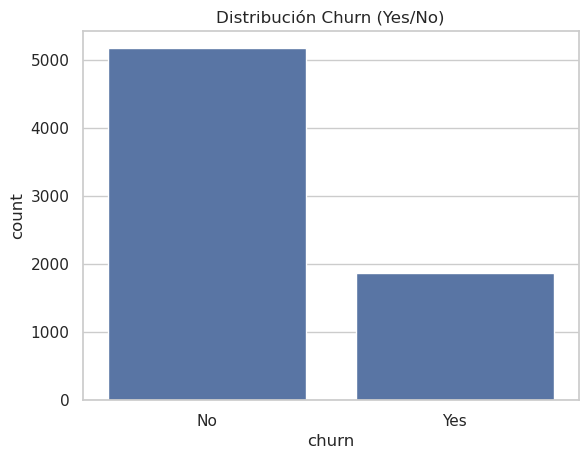

In [4]:
print("Target distribution:")
print(df['churn'].value_counts(normalize=True))
sns.countplot(x='churn', data=df)
plt.title('Distribución Churn (Yes/No)')
plt.show()

In [5]:
# Excluir columnas no informativas (customerID)
drop_cols = ['customerid'] if 'customerid' in df.columns else []
df = df.drop(columns=drop_cols)

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df, target='churn', test_size=0.2, val_size=0.1, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(4929, 19) (705, 19) (1409, 19)


In [7]:
preprocessor, numeric_features, low_card, high_card = build_preprocessor(pd.concat([X_train, y_train], axis=1))
print("Numeric:", numeric_features)
print("Low-card categorical:", low_card)
print("High-card categorical:", high_card)

Numeric: ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']
Low-card categorical: ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
High-card categorical: []


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Logistic (baseline)
log = LogisticRegression(max_iter=1000)

pipe_log = build_pipeline(preprocessor, log)
pipe_log.fit(X_train, y_train)
metrics_log = evaluate_model(pipe_log, X_val, y_val)
metrics_log

{'roc_auc': 0.8578035636859167,
 'precision': 0.7,
 'recall': 0.5614973262032086,
 'f1': 0.6231454005934718,
 'confusion_matrix': array([[473,  45],
        [ 82, 105]])}

In [11]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
pipe_rf = build_pipeline(preprocessor, rf)

# quick random search

param_dist = {
    'model__n_estimators': [100, 200, 400],
    'model__max_depth': [5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

rs = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print("Best RF ROC-AUC (val):", roc_auc_score(y_val, best_rf.predict_proba(X_val)[:,1]))

Best RF ROC-AUC (val): 0.8560279148514442


In [22]:
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
pipe_xgb = build_pipeline(preprocessor, xgb)
pipe_xgb.fit(X_train, y_train)
print("XGB ROC-AUC (val):", roc_auc_score(y_val, pipe_xgb.predict_proba(X_val)[:,1]))

XGB ROC-AUC (val): 0.8506803212685565


In [23]:
from sklearn.metrics import roc_auc_score
models = {'logistic': pipe_log, 'rf': best_rf, 'xgb': pipe_xgb}
for name, p in models.items():
    score = roc_auc_score(y_val, p.predict_proba(X_val)[:,1])
    print(name, score)

logistic 0.8578035636859167
rf 0.8560279148514442
xgb 0.8506803212685565


In [24]:
best_model = best_rf  # por ejemplo
metrics_test = evaluate_model(best_model, X_test, y_test)
metrics_test

{'roc_auc': 0.8406597948797437,
 'precision': 0.6763485477178424,
 'recall': 0.4358288770053476,
 'f1': 0.5300813008130081,
 'confusion_matrix': array([[957,  78],
        [211, 163]])}

In [25]:
save_model(best_model, path='../models/best_model.joblib')

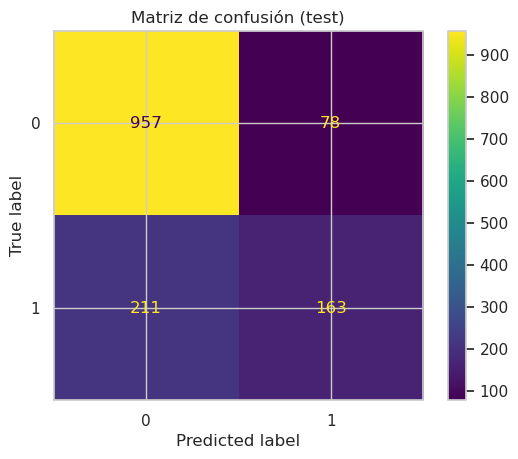

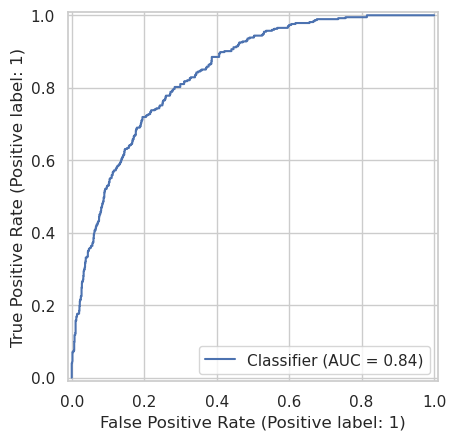

In [26]:
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

y_proba = best_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

# Confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Matriz de confusión (test)')
plt.show()

# ROC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

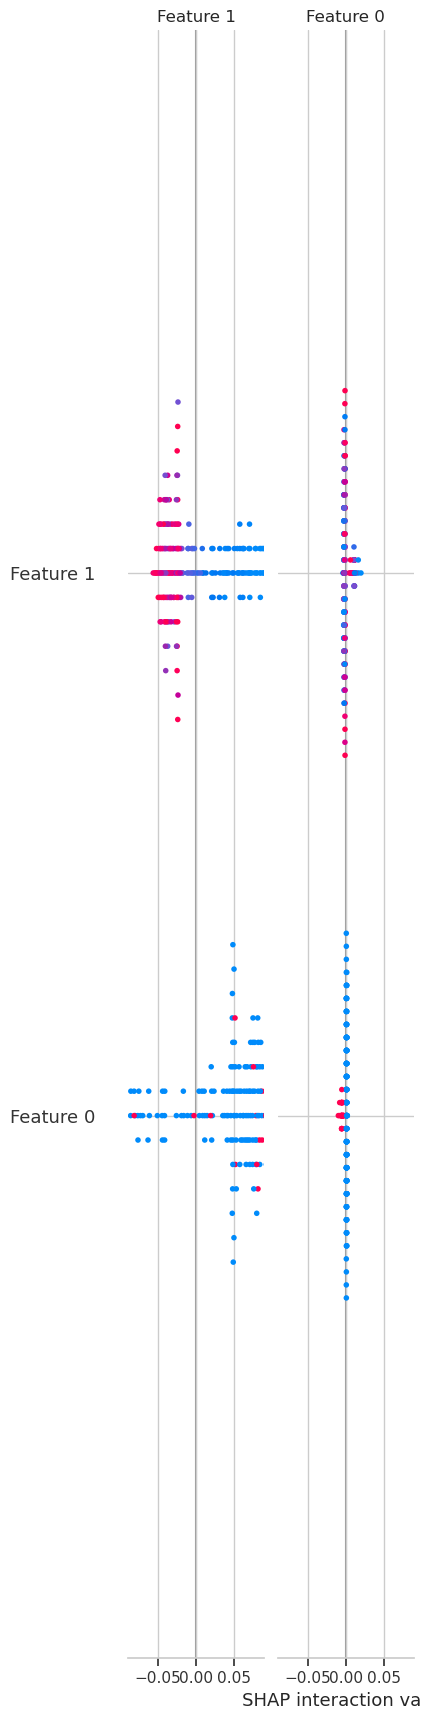

In [27]:
X_sample = X_test.sample(200, random_state=42)
shap_explain(best_model, X_sample)

## 📈 Conclusiones

1. **Los tres modelos presentan un desempeño sólido**, con métricas de **ROC-AUC** superiores a **0.85**, lo que indica una buena capacidad para distinguir entre clientes que abandonan y los que permanecen:

   | Modelo | ROC-AUC (Validación) |
   |:-------|:---------------------:|
   | Logistic Regression | **0.8578** |
   | Random Forest | 0.8560 |
   | XGBoost | 0.8507 |

2. Aunque la **Regresión Logística** obtiene el mejor rendimiento global, el **Random Forest** ofrece una excelente relación entre **precisión, robustez e interpretabilidad**, lo que lo convierte en una opción equilibrada para un entorno productivo.

3. El **recall (0.43)** indica que el modelo aún **no detecta todos los casos de abandono**, un comportamiento común en datasets desbalanceados.  
   🔧 Posibles mejoras:
   - Aplicar **técnicas de balanceo** (SMOTE, undersampling).  
   - Ajustar el **umbral de decisión (threshold)** para priorizar la detección de churners.  
   - Implementar **aprendizaje sensible al coste**, dando más peso a los falsos negativos.

4. La **matriz de confusión** evidencia que el modelo clasifica correctamente la mayoría de los clientes que permanecen (`957 TN`), pero comete **211 falsos negativos**.  
   👉 Esto significa que el modelo tiende a ser **conservador**, privilegiando la precisión sobre la sensibilidad.

5. Los modelos de árboles (**Random Forest y XGBoost**) confirman los patrones identificados en la exploración:
   - Las variables más influyentes según **SHAP** son la **antigüedad del cliente**, el **tipo de contrato**, y el **uso del servicio**.  
   - Los clientes con **planes mensuales** y **menor tiempo de permanencia** presentan una mayor probabilidad de abandono.

6. **Conclusión general:**  
   El modelo desarrollado ofrece una **base sólida para estrategias de retención de clientes**, permitiendo identificar perfiles con alto riesgo de abandono.  
   Aun así, el sistema puede mejorarse mediante:
   - Optimización de hiperparámetros.  
   - Reajuste del umbral de probabilidad.  
   - Calibración de probabilidades y validación cruzada estratificada.

---

## 💡 Recomendaciones futuras

- Implementar **validación cruzada estratificada** para mayor robustez.  
- Probar modelos más recientes como **LightGBM** o **CatBoost**.  
- Incluir variables de **comportamiento temporal** (frecuencia de uso, pagos, interacción).  
- Desarrollar un **dashboard de monitorización** con **Streamlit** o **PowerBI** para visualización de métricas y alertas en tiempo real.

---

## 🧩 Métricas de evaluación final

| Métrica | Valor |
|:---------|:------:|
| ROC-AUC | 0.8407 |
| Precisión | 0.6763 |
| Recall | 0.4358 |
| F1-Score | 0.5301 |

**Matriz de confusión:**

|   | Pred. No Churn | Pred. Churn |
|---|----------------:|------------:|
| **Real No Churn** | 957 | 78 |
| **Real Churn** | 211 | 163 |

---

> ✨ **Conclusión final:**  
> El modelo actual constituye una herramienta eficaz para predecir la pérdida de clientes.  
> Su implementación podría reducir el *churn rate* mediante intervenciones personalizadas y campañas preventivas de fidelización.

---